In [1]:
# Written using R version 4.0.0
library(readstata13)
library(survey)
library(xlsx)
library(data.table)

Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart




In [2]:
# Load Data
setwd("/Users/huangzhuoyi/Zoey/Stanford/RA/Surgery/KID project")

In [109]:
#---------------------------------
dat <- read.dta13("data/LT_CoreData_ChildAbuse_2006_2009_2012KID(5.26).dta")
# Looking at only pediatric patients
dat <- dat[dat$AGE < 18 & !is.na(dat$AGE),]

print(colnames(dat))
cols_to_keep = c("DISCWT", "AGE", "RACE", "YEAR", "ZIPINC_QRTL", "FEMALE", "PAY1", "totcost",
                 "Child_abuse", "DIED", "LOS", "ATYPE", "RECNUM", "xiss", "niss", "MDC", 
                 "HOSP_LOCTEACH", "HOSP_BEDSIZE", "HOSP_REGION", "NACHTYPE", "HOSP_CONTROL",
                 "event_primdx_traumaICD9", "event_anydx_traumaICD9")
dat <- dat[, cols_to_keep]
# Adjust using CPI to 2021 prices
dat[dat$YEAR == 2006,]$totcost <- dat[dat$YEAR == 2006,]$totcost * 1.292034
dat[dat$YEAR == 2009,]$totcost <- dat[dat$YEAR == 2009,]$totcost * 1.214122
dat[dat$YEAR == 2012,]$totcost <- dat[dat$YEAR == 2012,]$totcost * 1.134498
save.dta13(dat, "data/LT_CoreData_ChildAbuse_2006_2009_2012KID(5.26)_processed.dta")

In [3]:
dat <- read.dta13("data/LT_CoreData_ChildAbuse_2006_2009_2012KID(5.26)_processed.dta")
# Looking at only pediatric patients

In [4]:
dat$AGEGROUP <- NA
dat[dat$AGE < 18,]$AGEGROUP <- "12-17"
dat[dat$AGE <= 11, ]$AGEGROUP <- "8-11"
dat[dat$AGE <= 7, ]$AGEGROUP <- "4-7"
dat[dat$AGE <= 3, ]$AGEGROUP <- "1-3"
dat[dat$AGE <  1, ]$AGEGROUP <- "<1"

dat$SEVGROUP <- NA
dat[dat$niss <= 75,]$SEVGROUP <- ">25"
dat[dat$niss <= 24, ]$SEVGROUP <- "16-24"
dat[dat$niss <= 15, ]$SEVGROUP <- "0-15"

dat['DIED_ED'] = (dat['DIED'] == 1) & (dat['ATYPE'] == 1)
dat['DIED_IN'] = (dat['DIED'] == 1) & (dat['ATYPE'] != 1)

In [5]:
dim(dat) # 7861817 * 27

[1] 7861817      27

In [6]:
names(dat)

[1] "DISCWT"                  "AGE"                    
 [3] "RACE"                    "YEAR"                   
 [5] "ZIPINC_QRTL"             "FEMALE"                 
 [7] "PAY1"                    "totcost"                
 [9] "Child_abuse"             "DIED"                   
[11] "LOS"                     "ATYPE"                  
[13] "RECNUM"                  "xiss"                   
[15] "niss"                    "MDC"                    
[17] "HOSP_LOCTEACH"           "HOSP_BEDSIZE"           
[19] "HOSP_REGION"             "NACHTYPE"               
[21] "HOSP_CONTROL"            "event_primdx_traumaICD9"
[23] "event_anydx_traumaICD9"  "AGEGROUP"               
[25] "SEVGROUP"                "DIED_ED"                
[27] "DIED_IN"

# Defining Labels

In [7]:
# Define Sex Labels
dat$SEX <- factor(dat$FEMALE, levels = c(0,1), labels = c("Male", "Female"))
# Define Payer Labels according to KID Codebook: https://www.hcup-us.ahrq.gov/db/nation/kid/kiddde.jsp, excluding medicare (irrelevant)
dat$PAYER <- factor(dat$PAY1, levels = c(2,3,4,5,6), labels = c("Medicaid", "Private", "Self-pay", "No Charge", "Other"))
levels(dat$PAYER) <- c("Medicaid", "Private", "Self-pay", "Other", "Other")
dat$DIED <- factor(dat$DIED, levels = c(0, 1), labels = c("FALSE", "TRUE"))
dat$Child_abuse <- factor(dat$Child_abuse, levels = c(0,1), labels = c("Non-SCAN", "SCAN"))
dat$Child_abuse_indicator <- as.numeric(dat$Child_abuse == "SCAN")
dat$ZIPINC_QRTL <- factor(dat$ZIPINC_QRTL, levels = c(4,3,2,1), labels = c("4", "3", "2", "1"))
dat$HOSP_BEDSIZE <- factor(dat$HOSP_BEDSIZE, levels = c(1,2,3), labels = c("Small", "Medium", "Large"))
dat$HOSP_REGION <- factor(dat$HOSP_REGION, levels = c(1,2,3,4), labels = c("Northeast", "Midwest", "South", "West"))
dat$PRIMARY_TRAUMA <- factor(dat$event_primdx_traumaICD9, levels = c(0,1), labels = c("False", "True"))
dat$ANY_TRAUMA <- factor(dat$event_anydx_traumaICD9, levels = c(0,1), labels = c("False", "True"))
dat <- dat[dat$ANY_TRAUMA == "True", ]

In [117]:
dim(dat) # 284080 32

[1] 284080     32

# Delete Rows (with cells < 10)

In [118]:
# delete Admit type 4 Newborn + 6 Other 3462 deleted 2363
unique(dat$ATYPE)
# nrow(subset(dat, ATYPE==1))
# nrow(subset(dat, ATYPE==2))
# nrow(subset(dat, ATYPE==3))
# nrow(subset(dat, ATYPE==4))
# nrow(subset(dat, ATYPE==5))
# nrow(subset(dat, ATYPE==6))
tempdat<-dat[!(dat$ATYPE==4 | dat$ATYPE==6),]
dim(tempdat) # 281717 32
unique(tempdat$ATYPE)

[1]  1  2  5 NA  3  4  6

[1] 281717     32

[1]  1  2  5 NA  3

In [119]:
# delete column HOSP_CONTROL
tempdat = subset(tempdat, select=-c(HOSP_CONTROL))
names(tempdat) 
dim(tempdat) # 281717 31

[1] "DISCWT"                  "AGE"                    
 [3] "RACE"                    "YEAR"                   
 [5] "ZIPINC_QRTL"             "FEMALE"                 
 [7] "PAY1"                    "totcost"                
 [9] "Child_abuse"             "DIED"                   
[11] "LOS"                     "ATYPE"                  
[13] "RECNUM"                  "xiss"                   
[15] "niss"                    "MDC"                    
[17] "HOSP_LOCTEACH"           "HOSP_BEDSIZE"           
[19] "HOSP_REGION"             "NACHTYPE"               
[21] "event_primdx_traumaICD9" "event_anydx_traumaICD9" 
[23] "AGEGROUP"                "SEVGROUP"               
[25] "DIED_ED"                 "DIED_IN"                
[27] "SEX"                     "PAYER"                  
[29] "Child_abuse_indicator"   "PRIMARY_TRAUMA"         
[31] "ANY_TRAUMA"

[1] 281717     31

In [120]:
# delete NACHTYPE Children's Specialty (2) deleted 361
unique(tempdat$NACHTYPE)
tempdat<-tempdat[!(tempdat$NACHTYPE==2),]
dim(tempdat) # 281356 31
unique(tempdat$NACHTYPE)

[1]  0  3 NA  1  2

[1] 281356     31

[1]  0  3 NA  1

In [121]:
# delete HOSP_LOCTEACH Rural (1)
unique(tempdat$HOSP_LOCTEACH)
tempdat<-tempdat[!(tempdat$HOSP_LOCTEACH==1),]
dim(tempdat) # 271345 31
unique(tempdat$HOSP_LOCTEACH)

[1]  2  3  1 NA

[1] 271345     31

[1]  2  3 NA

In [122]:
# delete RACE Asian Native American Other (4,5,6)
unique(tempdat$RACE)
tempdat<-tempdat[!(tempdat$RACE==4 | tempdat$RACE==4 | tempdat$RACE==4),]
dim(tempdat) # 269576 31
unique(tempdat$RACE)

[1]  2 NA  1  3  5  6  4

[1] 269576     31

[1]  2 NA  1  3  5  6

In [123]:
# # Define Race Labels according to KID Codebook: https://www.hcup-us.ahrq.gov/db/nation/kid/kiddde.jsp
# tempdat$RACE <- factor(tempdat$RACE, levels = c(1,2,3), labels = c("White", "Black", "Hispanic"))
# # Define Admit Type Labels according to KID Codebook: https://www.hcup-us.ahrq.gov/db/nation/kid/kiddde.jsp
# tempdat$ADMIT_TYPE <- factor(tempdat$ATYPE, levels = c(1,2,3,5), labels = c("Emergency", "Urgent", "Elective", "Trauma Center"))
# tempdat$HOSP_LOCTEACH <- factor(tempdat$HOSP_LOCTEACH, levels = c(2,3), labels = c("Urban nonteaching", "Urban teaching"))
# tempdat$NACHTYPE <- factor(tempdat$NACHTYPE, levels = c(0,1,3), labels = c("Not Children's", "Children's General", "Children's unit of General"))


In [8]:
# Define Race Labels according to KID Codebook: https://www.hcup-us.ahrq.gov/db/nation/kid/kiddde.jsp
dat$RACE <- factor(dat$RACE, levels = c(1,2,3,4,5,6), labels = c("White", "Black", "Hispanic", "Asian or Pacific Islander", "Native American", "Other"))
# Define Admit Type Labels according to KID Codebook: https://www.hcup-us.ahrq.gov/db/nation/kid/kiddde.jsp
dat$ADMIT_TYPE <- factor(dat$ATYPE, levels = c(1,2,3,4,5,6), labels = c("Emergency", "Urgent", "Elective", "Newborn", "Trauma Center", "Other"))
dat$HOSP_LOCTEACH <- factor(dat$HOSP_LOCTEACH, levels = c(1,2,3), labels = c("Rural", "Urban nonteaching", "Urban teaching"))
dat$NACHTYPE <- factor(dat$NACHTYPE, levels = c(0,1,2,3), labels = c("Not Children's", "Children's General", "Children's Specialty", "Children's unit of General"))


In [9]:
dat$AGEGROUP <- factor(dat$AGEGROUP, levels = c("12-17", "8-11", "4-7", "1-3", "<1"), labels = c("12-17", "8-11", "4-7", "1-3", "<1"))
dat$SEVGROUP <- factor(dat$SEVGROUP, levels = c(">25", "16-24", "0-15"), labels = c(">25", "16-24", "0-15"))

In [10]:
dat$COSTPD <- ifelse(dat$LOS == 0, dat$totcost, dat$totcost / dat$LOS)

In [11]:
summary(dat$DISCWT)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6034  1.3440  1.4485  1.5001  1.6144  6.0193 

In [12]:
# Initialize survey design
# dat <- subset(dat, !is.na(dat$DISCWT) )
dat.w <- svydesign(ids = ~1, data = dat, weights = dat$DISCWT)
# dat.w <- svydesign(ids = ~1, data = dat)
options(survey.lonely.psu = "adjust")

In [13]:
dim(dat)

[1] 284080     34

In [14]:
# BEGIN: ANALYSIS
svy_freq_table <- function(design, categorical_variables, numerical_variables, column_variable, sheet_name, mean = TRUE){
  # Prep file writer
  wb <- loadWorkbook("Results.xlsx")
  sheets <- getSheets(wb)
  removeSheet(wb, sheetName = sheet_name)
  sheet <- createSheet(wb, sheetName = sheet_name)
  
  # Unique values of group
  groups <- unique(dat[column_variable])
  groups <- groups[!is.na(groups)]
  groups <- sort(groups)
  
  row = 1
  for (factor in categorical_variables){
    # Frequency Distribution
    counts <- round(svytable(as.formula(paste(paste("~",factor,sep=""),column_variable,sep="+")),design))
    # Percentage Distribution
    percent <-round(prop.table(svytable(as.formula(paste(paste("~",factor,sep=""),column_variable,sep="+")),design),margin=2)*100,1)

    # Merge counts and percents
    table <- as.data.frame(cbind(counts, percent))
    colnames(table) <- c(groups, paste(groups,"1",sep="."))
    for(i in 1:length(groups)){
      cols <- c(groups[i], paste(groups[i],"1",sep="."))
      combined <- paste(do.call(paste, c(table[cols],sep=" (")), "%)",sep ="")
      table[groups[i]] <- combined
    }
    table <- table[, (names(table) %in% groups)]
    temp <- rownames(table)
    table <- as.data.table(table)
    table <- as.data.frame(cbind(temp, table))
    colnames(table) <- c(factor, colnames(table)[-1])
    
    # Format output
    cs <- CellStyle(wb, alignment = Alignment(wrapText = TRUE, horizontal = "ALIGN_CENTER"))
    dfColIndex <- rep(list(cs), dim(table)[2])
    names(dfColIndex) <- seq(1, dim(table)[2], by = 1)
    addDataFrame(table, sheet, startRow = row, colStyle = dfColIndex, row.names = FALSE)
    autoSizeColumn(sheet, 1:ncol(table))
    row = row + nrow(table)+1
  }
  
  # Create population level statistics for numerical variables
  for (factor in numerical_variables){
    table = data.frame()
    for(i in 1:length(groups)){
      form = as.formula(paste("~",factor,sep=""))
      des = subset(design, eval(parse(text = column_variable)) == groups[i])
      
      # Mean and standard error
      if (mean){
        res = svymean(form, des, na.rm=TRUE)
        res <- paste(round(coef(res), 3), paste(round(SE(res), 3),")", sep = ""), sep=" (")
      }
      # Median and [Q1, Q3]
      else{
        res = round(unname(svyquantile(form, des, na.rm = TRUE, quantiles = c(.25, .5, .75))), 2)
        res = paste(res[,2],paste("  [", paste( res[,1], paste (",", paste(res[,3], "]", sep = "")), sep = ""), sep = ""), sep = "")          
      }
      table = rbind(table, res)
    }
    table <- as.data.table(t(table))
    colnames(table) <- groups
    table <- as.data.frame(table)
    rownames(table) <- factor
    cs <- CellStyle(wb, alignment = Alignment(wrapText = TRUE, horizontal = "ALIGN_CENTER"))
    dfColIndex <- rep(list(cs), dim(table)[2])
    names(dfColIndex) <- seq(1, dim(table)[2], by = 1)
    addDataFrame(table, sheet, startRow = row, colStyle = dfColIndex, row.names = TRUE)
    autoSizeColumn(sheet, 1:ncol(table))
    row = row + nrow(table)+1
    
  }
  saveWorkbook(wb, "Results.xlsx")
}

In [15]:
svy_freq_table_over_group <- function(design, group, factors, outcome, sheet_name, mean = TRUE, verbose = FALSE){
  # Prep file writer
  wb <- loadWorkbook("Results.xlsx")
  sheets <- getSheets(wb)
  removeSheet(wb, sheetName = sheet_name)
  sheet <- createSheet(wb, sheetName = sheet_name)
  
  # Unique values of group
  groups <- unique(dat[group])
  groups <-groups[!is.na(groups)]
  groups <- sort(groups)
  
  row = 1
  for (factor_choice in factors){
    # Frequency Distribution
    counts <- round(svytable(as.formula(paste(paste("~",factor_choice,sep=""),group,sep="+")),design))
    # Percentage Distribution
    percent <-round(prop.table(svytable(as.formula(paste(paste("~",factor_choice,sep=""),group,sep="+")),design),margin=2)*100,1)
    
    # Median Outcome Distribution
    if (outcome != ""){
      outcomes = c()
      vals <- unique(dat[factor_choice])
      vals <- vals[!is.na(vals)]
      for (val in vals){
        temp = c()
        for (group_choice in groups){
          form = as.formula(paste("~",outcome,sep=""))
          des = subset(design, eval(parse(text = factor_choice)) == val & eval(parse(text = group)) == group_choice)
          # Mean for outcome of interest
          if (mean){
            res = round(unname(svymean(form, des, na.rm = TRUE)), 2)
          }
          # Median and [Q1, Q3] for outcome of interest
          else{
            res = round(unname(svyquantile(form, des, na.rm = TRUE, quantiles = c(.25, .5, .75))), 2)
            res = paste(res[,2],paste("  [", paste( res[,1], paste (",", paste(res[,3], "]", sep = "")), sep = ""), sep = ""), sep = "")          
          }
          temp = cbind(temp, res)
        }
        temp <- as.data.frame(temp)
        outcomes = rbind(outcomes, temp)
      }
      outcomes <- as.data.table(outcomes)
      outcomes <- as.data.frame(cbind(vals, outcomes))
      colnames(outcomes) <- c(factor_choice, groups)
    }
    
    # Chisq test for difference in distribution (not outcome)
    p <- svychisq(as.formula(paste(paste("~",group,sep=""),factor_choice,sep="+")),design, "F")$p.value
    p <- signif(p, 3)
    
    # Merge counts and percents
    table <- as.data.frame(cbind(counts, percent))
    colnames(table) <- c(groups, paste(groups,"1",sep="."))
    for(i in 1:length(groups)){
      cols <- c(groups[i], paste(groups[i],"1",sep="."))
      temp <- do.call(paste, c(table[cols],sep=" ("))
      temp <- paste(temp, "%)",sep ="")
      
      cols <- c(groups[i], paste(groups[i],"1",sep="."))
      table <- table[, !(names(table) %in% cols)]
      table[groups[i]] <- temp
    }
    temp <- rownames(table)
    table <- as.data.table(table)
    table <- as.data.frame(cbind(temp, table))
    
    # Merge incidence with outcomes
    if (outcome != ""){
      cols <- c(paste(groups,"2",sep="."))
      colnames(table) <- c(factor_choice, cols)
      table <- merge(table, outcomes, by = factor_choice)
      for(i in 1:length(groups)){
        cols <- c(paste(groups[i],"2",sep="."), groups[i])
        for (j in 1:length(table[groups[i]])){
          table[groups[i]][j] = format(table[groups[i]][j], format="d", big.mark=",")
        }
        temp <- do.call(paste, c(table[cols],sep="\n "))
        
        cols <- c(groups[i], paste(groups[i],"2",sep="."))
        table <- table[, !(names(table) %in% cols)]
        table[groups[i]] <- temp
      }
    }
    # Add p-values to table
    table$p.value <- c(p, rep("",times=nrow(table)-1))
    if(verbose){
      print(table)
    }
    # Format output
    cs <- CellStyle(wb, alignment = Alignment(wrapText = TRUE, horizontal = "ALIGN_CENTER"))
    dfColIndex <- rep(list(cs), dim(table)[2])
    names(dfColIndex) <- seq(1, dim(table)[2], by = 1)
    addDataFrame(table, sheet, startRow = row, colStyle = dfColIndex, row.names = FALSE)
    autoSizeColumn(sheet, 1:ncol(table))
    row = row + nrow(table)+1
  }
  saveWorkbook(wb, "Results.xlsx")
}


# Create ISS LOS Age table

In [93]:
table(dat['SEVGROUP'])


  >25 16-24  0-15 
 4919 10902 91435 

In [94]:
library(dplyr)
library(vcd)
# age <= 3 child_abuse = Non-SCAN
# get all age<3 non scan patients
dat1 = filter(dat, AGE <= 3 & Child_abuse == 'Non-SCAN')
dim(dat1)
res1 = dat1 %>% group_by(RACE, SEVGROUP) %>% summarise(Mean_LOS = mean(LOS, na.rm = TRUE))
res_med = dat1 %>% group_by(RACE, SEVGROUP) %>% summarise(Mean_LOS = mean(LOS, na.rm = TRUE))
res2 = dat1 %>% group_by(RACE, SEVGROUP) %>% summarise(qs = quantile(LOS, c(0.25, 0.75), na.rm = TRUE), prob = c(0.25, 0.75), n = n())
tab1 <- xtabs(Mean_LOS ~ RACE+SEVGROUP, data=res1)
tab2 <- xtabs(qs ~ RACE+SEVGROUP, data=res2)
tab3 <- xtabs(n ~ RACE+SEVGROUP, data=res2)
print("age <= 3 child_abuse = Non-SCAN")
tab1
res2
tab2
tab3


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 19609    33

`summarise()` has grouped output by 'RACE'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'RACE'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'RACE', 'SEVGROUP'. You can override using the `.groups` argument.



[1] "age <= 3 child_abuse = Non-SCAN"


          SEVGROUP
RACE             >25     16-24      0-15
  White     9.051181  5.169608  2.862676
  Black    10.918182  6.790634  3.639706
  Hispanic  9.673267  4.763415  2.854777

RACE,SEVGROUP,qs,prob,n
<fct>,<fct>,<dbl>,<dbl>,<int>
White,>25,2.00,0.25,254
White,>25,12.00,0.75,254
White,16-24,1.00,0.25,1020
White,16-24,5.00,0.75,1020
White,0-15,1.00,0.25,8805
White,0-15,2.00,0.75,8805
White,NA,3.00,0.25,91
White,NA,10.00,0.75,91
Black,>25,2.00,0.25,110


          SEVGROUP
RACE       >25 16-24 0-15
  White     14     6    3
  Black     16     7    4
  Hispanic  14     6    4

          SEVGROUP
RACE         >25 16-24  0-15
  White      508  2040 17610
  Black      220   726  5714
  Hispanic   202   822  7850

In [95]:
library("vcd")
chisq <-chisq.test(tab3)

In [96]:
chisq


	Pearson's Chi-squared test

data:  tab3
X-squared = 30.158, df = 4, p-value = 4.544e-06


In [97]:
df1 = as.data.frame.matrix(tab1)
df1
abuse_race_tb[abuse_race_tb$P_value < 0.01, ]$P_value <- '<0.01'

,>25,16-24,0-15
,<dbl>,<dbl>,<dbl>
White,9.051181,5.169608,2.862676
Black,10.918182,6.790634,3.639706
Hispanic,9.673267,4.763415,2.854777


ERROR: Error in abuse_race_tb[abuse_race_tb$P_value < 0.01, ]$P_value <- "<0.01": object 'abuse_race_tb' not found


In [98]:
# age <= 3 child_abuse = SCAN
dat2 = filter(dat, AGE <= 3 & Child_abuse == 'SCAN')
dim(dat2)
res2 = dat2 %>% group_by(RACE, SEVGROUP) %>% summarise(Mean_LOS = mean(LOS, na.rm = TRUE))
tab2 <- xtabs(Mean_LOS ~ RACE+SEVGROUP, data=res2)
print("age <= 3 child_abuse = SCAN")
tab2

[1] 1767   33

`summarise()` has grouped output by 'RACE'. You can override using the `.groups` argument.



[1] "age <= 3 child_abuse = SCAN"


          SEVGROUP
RACE             >25     16-24      0-15
  White    12.452830  8.930303  5.259657
  Black    11.090909 12.741935  6.700000
  Hispanic 13.421053  8.126316  5.851351

In [38]:
dat2c = filter(dat2, RACE=='Asian or Pacific Islander')
dim(dat2c)
dat2c[, c('DISCWT', 'RACE', 'LOS', 'SEVGROUP')]

[1] 39 34

DISCWT,RACE,LOS,SEVGROUP
<dbl>,<fct>,<int>,<fct>
1.843069,Asian or Pacific Islander,22,16-24
1.393260,Asian or Pacific Islander,12,16-24
1.393260,Asian or Pacific Islander,12,0-15
1.803242,Asian or Pacific Islander,6,16-24
1.443080,Asian or Pacific Islander,13,16-24
1.435720,Asian or Pacific Islander,26,0-15
1.435720,Asian or Pacific Islander,9,>25
1.843069,Asian or Pacific Islander,5,0-15
1.453931,Asian or Pacific Islander,7,>25


In [23]:
# age <= 5 child_abuse = Non-SCAN
dat3 = filter(dat, AGE <= 5 & Child_abuse == 'Non-SCAN')
dim(dat3)
res3 = dat3 %>% group_by(RACE, SEVGROUP) %>% summarise(Mean_LOS = mean(LOS, na.rm = TRUE))
tab3 <- xtabs(Mean_LOS ~ RACE+SEVGROUP, data=res3)
print("age <= 5 child_abuse = Non-SCAN")
tab3

[1] 74326    34

`summarise()` has grouped output by 'RACE'. You can override using the `.groups` argument.



[1] "age <= 5 child_abuse = Non-SCAN"


                           SEVGROUP
RACE                              >25     16-24      0-15
  White                      9.369403  5.229022  3.101479
  Black                     13.180602  7.251416  4.345537
  Hispanic                  10.047146  5.515797  3.104214
  Asian or Pacific Islander 12.591837  4.335260  3.436601
  Native American            8.521739  6.852632  3.345972
  Other                     10.484127  5.948052  4.155928

In [24]:
# age <= 5 child_abuse = SCAN
dat4 = filter(dat, AGE <= 5 & Child_abuse == 'SCAN')
dim(dat4)
res4 = dat4 %>% group_by(RACE, SEVGROUP) %>% summarise(Mean_LOS = mean(LOS, na.rm = TRUE))
tab4 <- xtabs(Mean_LOS ~ RACE+SEVGROUP, data=res4)
print("age <= 5 child_abuse = SCAN")
tab4

[1] 4947   34

`summarise()` has grouped output by 'RACE'. You can override using the `.groups` argument.



[1] "age <= 5 child_abuse = SCAN"


                           SEVGROUP
RACE                              >25     16-24      0-15
  White                     10.426966  8.802941  5.196689
  Black                     11.295455 12.126394  6.522305
  Hispanic                  15.672897 10.906716  5.861111
  Asian or Pacific Islander  7.714286 12.157895  4.937500
  Native American           16.400000 13.529412  3.850000
  Other                     13.500000 11.980769  6.566372

In [31]:
dat4c = filter(dat4, RACE=='Asian or Pacific Islander')
dim(dat4c)
dat4c[, c('DISCWT', 'RACE', 'LOS')]

[1] 42 34

DISCWT,RACE,LOS
<dbl>,<fct>,<int>
1.843069,Asian or Pacific Islander,22
1.393260,Asian or Pacific Islander,12
1.393260,Asian or Pacific Islander,12
1.803242,Asian or Pacific Islander,6
1.443080,Asian or Pacific Islander,13
1.435720,Asian or Pacific Islander,26
1.435720,Asian or Pacific Islander,9
1.843069,Asian or Pacific Islander,5
1.453931,Asian or Pacific Islander,7


In [19]:
# age all child_abuse = Non-SCAN
dat5 = filter(dat, Child_abuse == 'Non-SCAN')
dim(dat5)
res5 = dat5 %>% group_by(RACE, SEVGROUP) %>% summarise(Mean_LOS = mean(LOS, na.rm = TRUE))
tab5 <- xtabs(Mean_LOS ~ RACE+SEVGROUP, data=res5)
print("age all child_abuse = Non-SCAN")
tab5

[1] 278726     34

`summarise()` has grouped output by 'RACE'. You can override using the `.groups` argument.



[1] "age all child_abuse = Non-SCAN"


                           SEVGROUP
RACE                              >25     16-24      0-15
  White                     10.771760  5.790970  3.004779
  Black                     12.873404  7.240881  3.658971
  Hispanic                  11.773077  6.450520  3.063848
  Asian or Pacific Islander 10.671642  5.769841  3.285159
  Native American           13.530973  6.897887  3.527264
  Other                     12.250000  6.104530  3.717380

In [126]:
dunnetts_test <- function(Child_abuse_in, SEVGROUP_in, dat_in){
    dat_temp = filter(dat_in, Child_abuse == Child_abuse_in, SEVGROUP == SEVGROUP_in)[c("RACE","LOS")]
    print(dim(dat_temp))
    print("box-plot:")
    boxplot(LOS ~ RACE,
        data = dat_temp,
        main = sprintf("LOS distribution for all age, Child_abuse:%s, ISS:%s", Child_abuse_in, SEVGROUP_in),
        xlab = "Groups",
        ylab = "LOS",
        col = "red",
        border = "black")
    model <- aov(LOS ~ RACE, data = dat_temp)
    print(summary(model))
    dtest = DunnettTest(x=dat_temp$LOS, g=dat_temp$RACE)
#     print(dtest)
    dtable = do.call(rbind.data.frame, dtest)
    dtable$pvalc = dtable$pval
    pval1 <- dtable$pval < 0.1
    dtable$pvalc[pval1] <- '<0.1'
    pval2 <- dtable$pval < 0.05
    dtable$pvalc[pval2] <- '<0.05'
    pval3 <- dtable$pval < 0.01
    dtable$pvalc[pval3] <- '<0.01'
    pval4 <- dtable$pval < 0.001
    dtable$pvalc[pval4] <- '<0.001'
    dtable
}
    

[1] 12338     2
[1] "box-plot:"
               Df  Sum Sq Mean Sq F value  Pr(>F)    
RACE            5    7426    1485    6.37 6.4e-06 ***
Residuals   10216 2380020     233                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2116 observations deleted due to missingness


,diff,lwr.ci,upr.ci,pval,pvalc
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
White.Black-White,2.10164,1.043738,3.1596,1.7151e-06,<0.001
White.Hispanic-White,1.00132,-0.052371,2.0550,7.0688e-02,<0.1
White.Asian or Pacific Islander-White,-0.10012,-2.912809,2.7126,1.0000e+00,0.999997830657854
White.Native American-White,2.75921,-0.964374,6.4828,2.5138e-01,0.251384483395978
White.Other-White,1.47824,-0.335852,3.2923,1.6727e-01,0.167268613673321


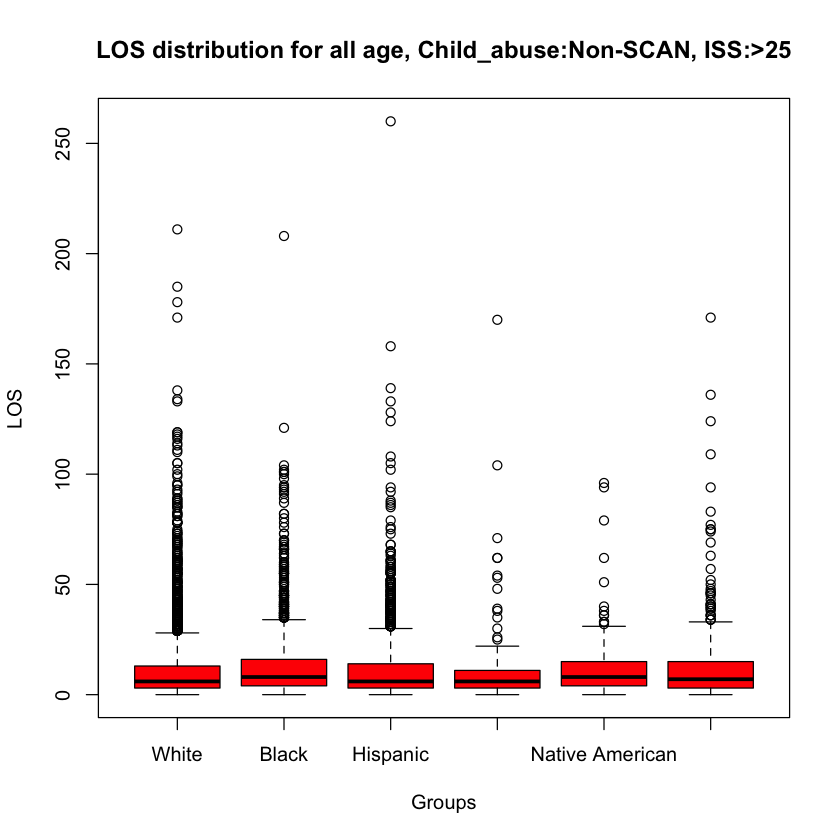

In [127]:
dunnetts_test("Non-SCAN", ">25", dat)

[1] 27174     2
[1] "box-plot:"
               Df  Sum Sq Mean Sq F value  Pr(>F)    
RACE            5    6087    1217    12.3 6.7e-12 ***
Residuals   22399 2223385      99                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
4769 observations deleted due to missingness


,diff,lwr.ci,upr.ci,pval,pvalc
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
White.Black-White,1.449911,0.94427,1.9556,9.3292e-13,<0.001
White.Hispanic-White,0.659550,0.20326,1.1158,1.0305e-03,<0.01
White.Asian or Pacific Islander-White,-0.021129,-1.18257,1.1403,1.0000e+00,0.999999924439481
White.Native American-White,1.106917,-0.42779,2.6416,2.7838e-01,0.278381213782894
White.Other-White,0.313560,-0.47393,1.1010,8.3551e-01,0.835509944553927


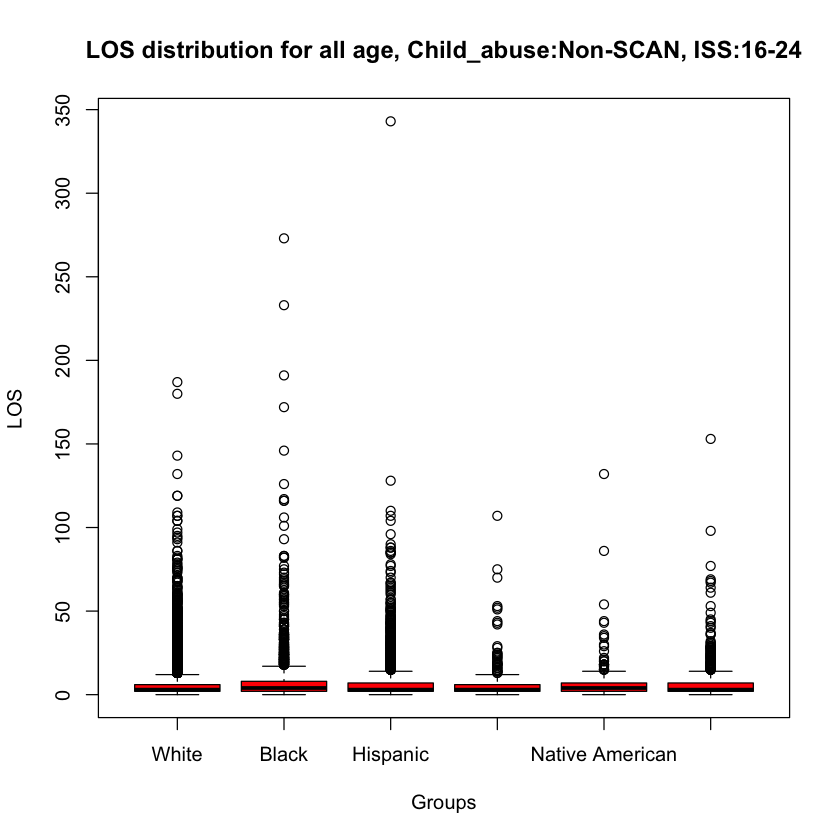

In [128]:
dunnetts_test("Non-SCAN", "16-24", dat)

[1] 238352      2
[1] "box-plot:"
                Df   Sum Sq Mean Sq F value Pr(>F)    
RACE             5    13748    2750    41.2 <2e-16 ***
Residuals   194713 12983784      67                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
43633 observations deleted due to missingness


,diff,lwr.ci,upr.ci,pval,pvalc
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
White.Black-White,0.654192,0.516233,0.79215,0.0000e+00,<0.001
White.Hispanic-White,0.059068,-0.063939,0.18208,7.0068e-01,0.700679494226123
White.Asian or Pacific Islander-White,0.280380,-0.042975,0.60373,1.2204e-01,0.122037305937656
White.Native American-White,0.522485,0.055505,0.98946,2.0078e-02,<0.05
White.Other-White,0.712601,0.493719,0.93148,2.2204e-16,<0.001


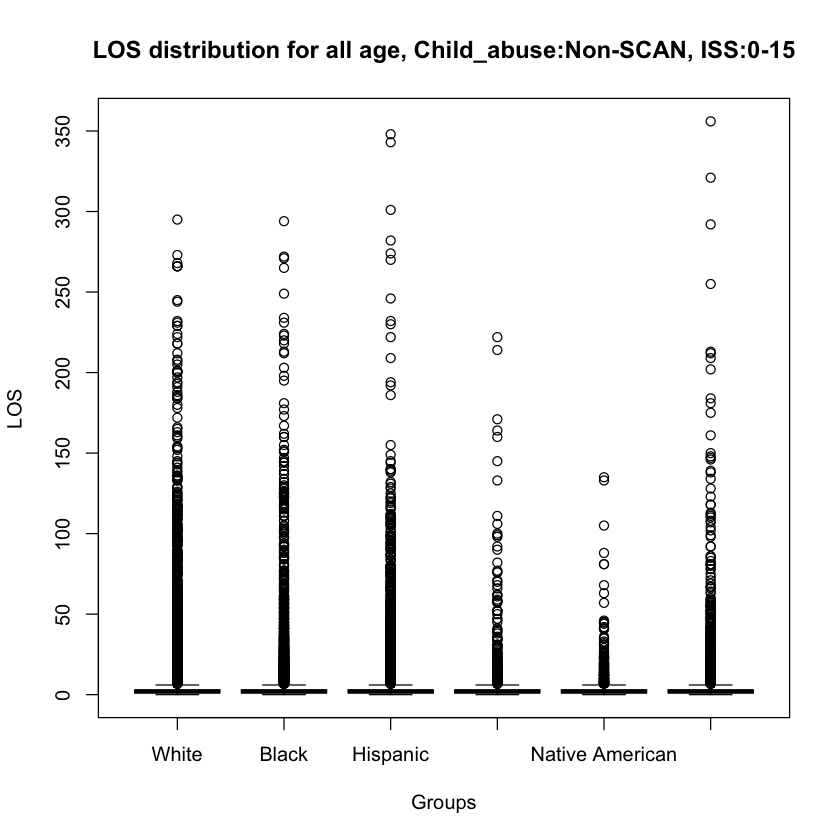

In [129]:
dunnetts_test("Non-SCAN", "0-15", dat)

[1] 727   2
[1] "box-plot:"
             Df Sum Sq Mean Sq F value Pr(>F)  
RACE          5   2529     506    1.95  0.084 .
Residuals   578 149924     259                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
143 observations deleted due to missingness


,diff,lwr.ci,upr.ci,pval,pvalc
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
White.Black-White,0.61383,-3.74910,4.9768,0.998003,0.99800255577527
White.Hispanic-White,5.13235,0.43452,9.8302,0.025014,<0.05
White.Asian or Pacific Islander-White,-3.15336,-19.01695,12.7102,0.989974,0.989973657581394
White.Native American-White,5.53235,-7.81124,18.8760,0.805118,0.805118058145679
White.Other-White,2.64216,-3.68145,8.9658,0.800117,0.800116915985309


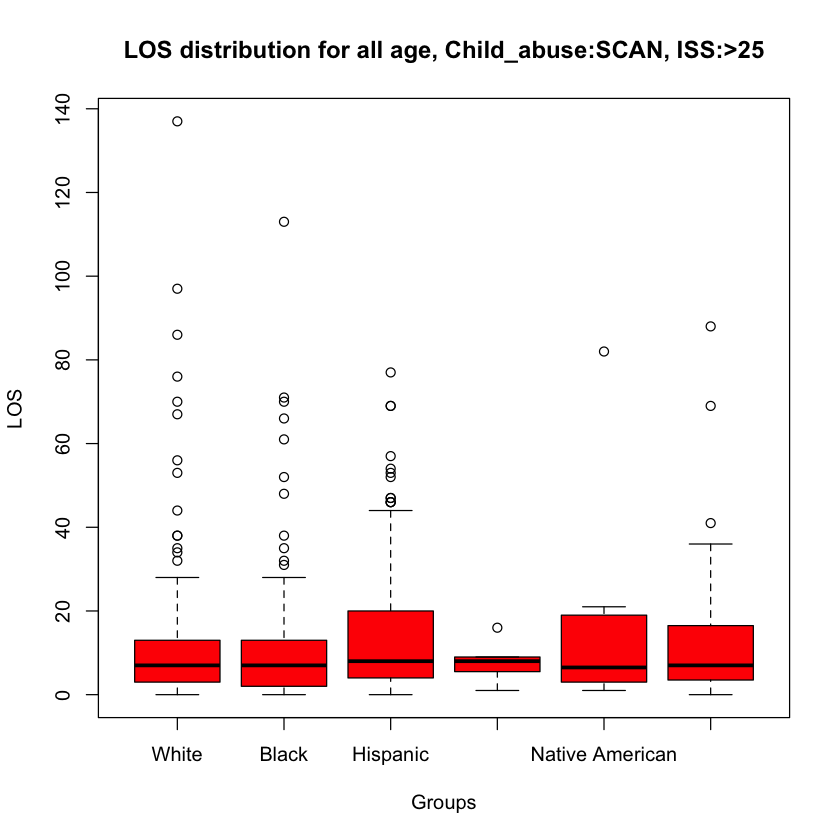

In [130]:
dunnetts_test("SCAN", ">25", dat)

[1] 1683    2
[1] "box-plot:"
              Df Sum Sq Mean Sq F value Pr(>F)   
RACE           5   2915     583     3.1 0.0087 **
Residuals   1365 256957     188                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
312 observations deleted due to missingness


,diff,lwr.ci,upr.ci,pval,pvalc
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
White.Black-White,3.2003,0.67638,5.7243,0.0057112,<0.01
White.Hispanic-White,2.1014,-0.42252,4.6254,0.1499695,0.149969458328627
White.Asian or Pacific Islander-White,3.3436,-4.85628,11.5434,0.8181669,0.818166882279033
White.Native American-White,4.7151,-3.94136,13.3715,0.5767189,0.576718880069483
White.Other-White,3.0809,-0.61438,6.7762,0.1489383,0.148938282494492


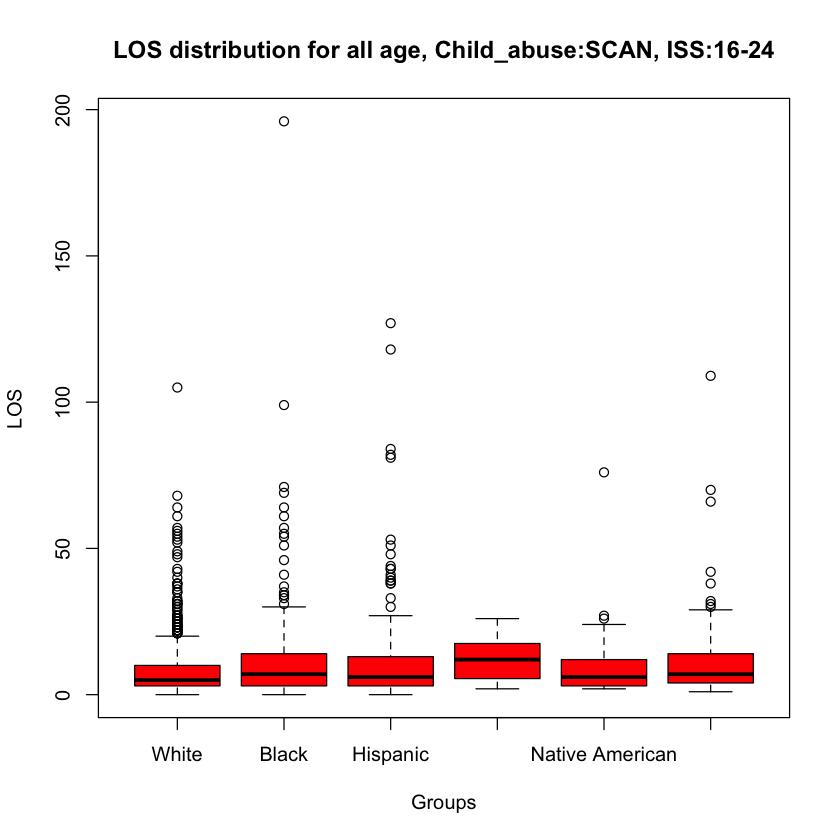

In [131]:
dunnetts_test("SCAN", "16-24", dat)

[1] 2923    2
[1] "box-plot:"
              Df Sum Sq Mean Sq F value Pr(>F)
RACE           5   1035     207    1.81   0.11
Residuals   2459 281790     115               
458 observations deleted due to missingness


,diff,lwr.ci,upr.ci,pval,pvalc
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
White.Black-White,1.329706,-0.03381,2.6932,0.059381,<0.1
White.Hispanic-White,0.244048,-1.22402,1.7121,0.995708,0.995707717361617
White.Asian or Pacific Islander-White,-0.837560,-6.62632,4.9512,0.997772,0.997771752444484
White.Native American-White,-0.011473,-5.80023,5.7773,1.000000,0.999999999998785
White.Other-White,1.819444,-0.68120,4.3201,0.267624,0.267624438633846


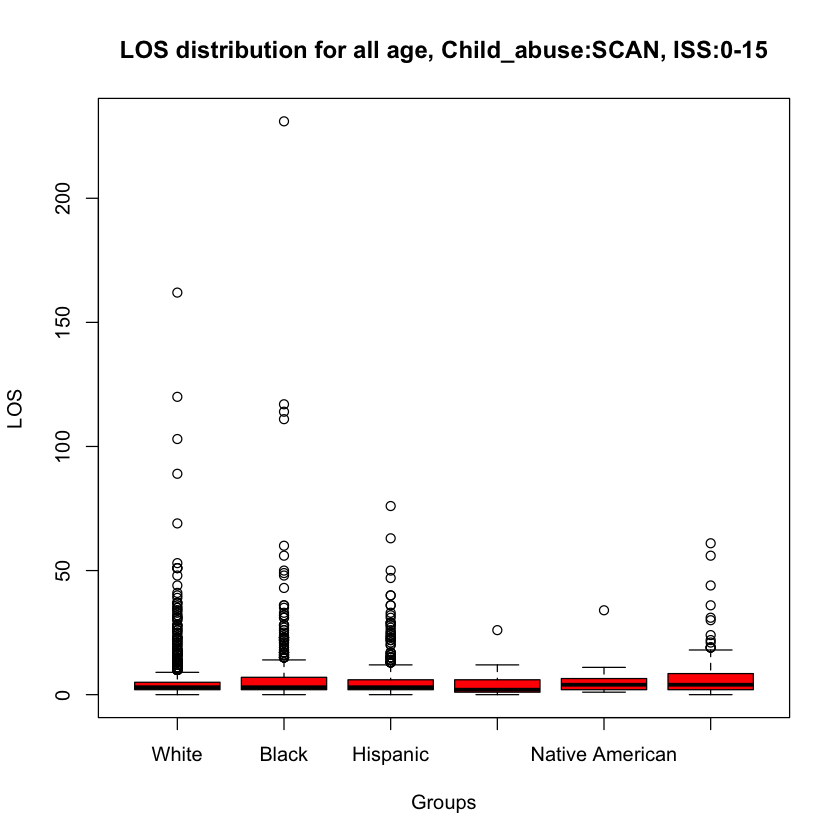

In [132]:
dunnetts_test("SCAN", "0-15", dat)

# Use Dunnetts test, keep race as a variable, control ISS, take LOS as measurement

In [84]:
datns = filter(dat, Child_abuse == 'Non-SCAN')[c("RACE","LOS")]
dats = filter(dat, Child_abuse == 'SCAN')[c("RACE","LOS")]
dim(datns)
dim(dats)

[1] 278726      2

[1] 5354    2

## 1. Visualize the values for each group.

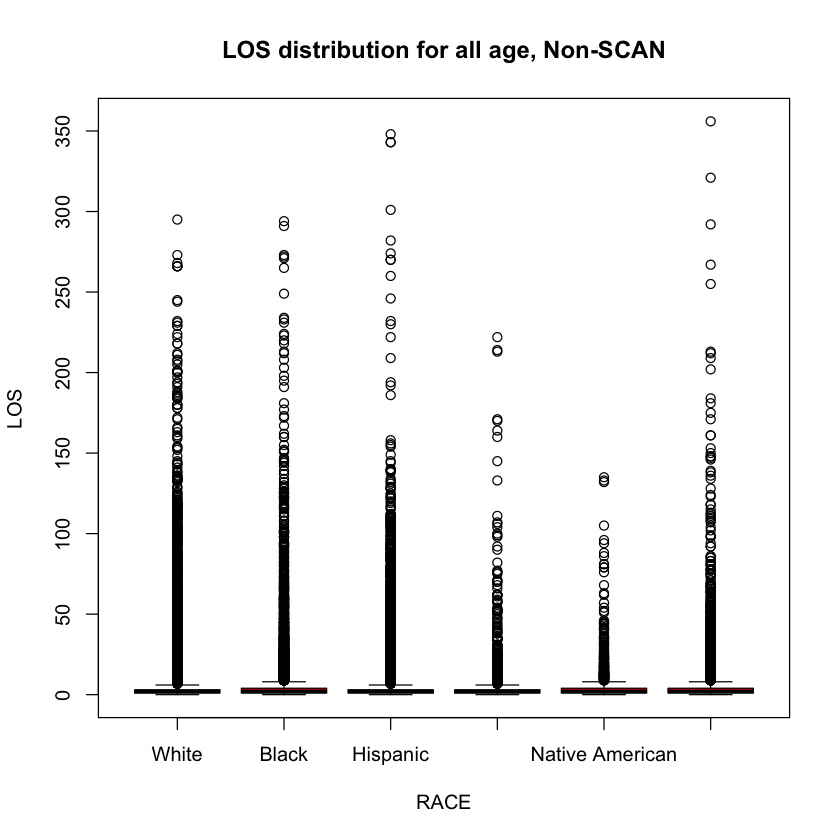

In [85]:
boxplot(LOS ~ RACE,
        data = datns,
        main = "LOS distribution for all age, Non-SCAN",
        xlab = "RACE",
        ylab = "LOS",
        col = "red",
        border = "black")

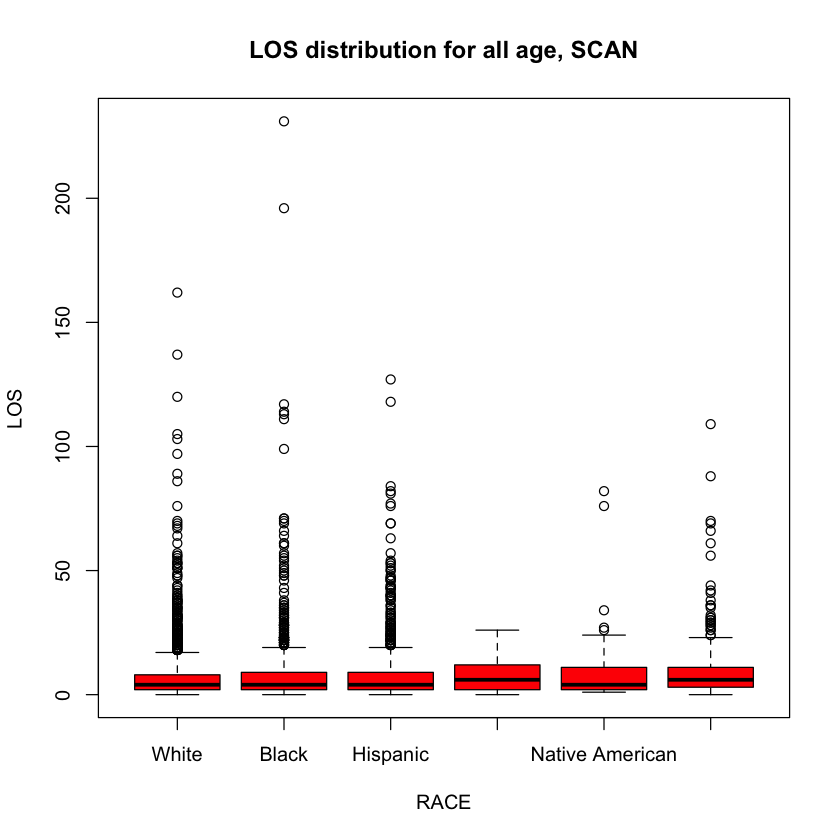

In [86]:
boxplot(LOS ~ RACE,
        data = dats,
        main = "LOS distribution for all age, SCAN",
        xlab = "RACE",
        ylab = "LOS",
        col = "red",
        border = "black")

## 2. ANOVA Comparison

We can calculate F and p values using the aov function. Let’s put the model together.

In [87]:
model <- aov(LOS ~ RACE, data = datns)
summary(model)

                Df   Sum Sq Mean Sq F value Pr(>F)    
RACE             5    24469    4894    58.1 <2e-16 ***
Residuals   228077 19222870      84                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
50643 observations deleted due to missingness

In [88]:
model <- aov(LOS ~ RACE, data = dats)
summary(model)

              Df Sum Sq Mean Sq F value  Pr(>F)    
RACE           5   3568     714    4.37 0.00057 ***
Residuals   4431 724008     163                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
917 observations deleted due to missingness

Based on the ANOVA model the p-value is statistically significant (p<0.001), indicate that each group does not have the same average values.

Let’s perform Dunnett’s test and identify which groups are statistically significant.

## 3. Dunnett’s Test.

We can make use of DunnettTest() function from the DescTools package.

Dunnett’s Function syntax is as follows, where:

DunnettTest(x, g)

x: Numerical values

g: Group Names

Let’s load the library and perform Dunnett’s test

In [89]:
# install.packages("DescTools")

In [90]:
library(DescTools)

In [100]:
dtest1 = DunnettTest(x=datns$LOS, g=datns$RACE)
typeof(dtest1)

[1] "list"

In [101]:
dtest1


  Dunnett's test for comparing several treatments with a control :  
    95% family-wise confidence level

$White
                                   diff    lwr.ci  upr.ci    pval    
Black-White                     0.84791  0.704817 0.99100 < 2e-16 ***
Hispanic-White                  0.14357  0.015211 0.27193  0.0201 *  
Asian or Pacific Islander-White 0.22943 -0.106859 0.56573  0.3359    
Native American-White           0.84653  0.366907 1.32616 2.9e-05 ***
Other-White                     0.76367  0.536307 0.99104 < 2e-16 ***

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [102]:
dtable1 = do.call(rbind.data.frame, dtest1)

In [103]:
dtable1

,diff,lwr.ci,upr.ci,pval
,<dbl>,<dbl>,<dbl>,<dbl>
White.Black-White,0.84791,0.704817,0.99100,0.0000e+00
White.Hispanic-White,0.14357,0.015211,0.27193,2.0147e-02
White.Asian or Pacific Islander-White,0.22943,-0.106859,0.56573,3.3593e-01
White.Native American-White,0.84653,0.366907,1.32616,2.9174e-05
White.Other-White,0.76367,0.536307,0.99104,0.0000e+00


In [104]:

# dtable1[dtable1$pval < 0.001, ]$pval <- '<0.001'
# dtable1[dtable1$pval < 0.05, ]$pval <- '<0.05'
# dtable1[dtable1$pval < 0.01, ]$pval <- '<0.01'

In [105]:
dtable1

,diff,lwr.ci,upr.ci,pval,pvalc
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
White.Black-White,0.84791,0.704817,0.99100,0.0000e+00,<0.001
White.Hispanic-White,0.14357,0.015211,0.27193,2.0147e-02,<0.05
White.Asian or Pacific Islander-White,0.22943,-0.106859,0.56573,3.3593e-01,NA
White.Native American-White,0.84653,0.366907,1.32616,2.9174e-05,<0.001
White.Other-White,0.76367,0.536307,0.99104,0.0000e+00,<0.001


In [99]:
DunnettTest(x=dats$LOS, g=dats$RACE)


  Dunnett's test for comparing several treatments with a control :  
    95% family-wise confidence level

$White
                                   diff    lwr.ci upr.ci   pval    
Black-White                     1.55710  0.315015 2.7992 0.0065 ** 
Hispanic-White                  1.33552  0.024836 2.6462 0.0434 *  
Asian or Pacific Islander-White 0.71782 -4.023679 5.4593 0.9972    
Native American-White           3.11864 -1.576294 7.8136 0.3624    
Other-White                     2.74836  0.699787 4.7969 0.0029 ** 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


(Given Non-SCAN)<br>
The LOS of Black group significantly 0.8479 higher compared to White (p<0.001).<br>
The LOS of Hispanic group also significantly 0.1436 higher compared to White (p<0.05). <br>
The LOS of Native American-White group also significantly 0.8465 higher compared to White (p<0.001). <br>

(Given SCAN)<br>
The LOS of Black group significantly 1.5571 higher compared to White (p<0.01).<br>
The LOS of Hispanic group also significantly 1.3355 higher compared to White (p<0.05). <br>

(Calculate increase for SCAN compared with Non-SCAN) <br>
The increase of LOS for SCAN compared with Non-SCAN for Black group: 1.5571 - 0.8479 = 0.7092 <br>
The increase of LOS for SCAN compared with Non-SCAN for Hispanic group: 1.3355 - 0.1436 = 1.1919 <br>

In [34]:
# age all child_abuse = SCAN
dat6 = filter(dat, Child_abuse == 'SCAN')
dim(dat6)
res6 = dat6 %>% group_by(RACE, SEVGROUP) %>% summarise(Mean_LOS = mean(LOS, na.rm = TRUE))
tab6 <- xtabs(Mean_LOS ~ RACE+SEVGROUP, data=res6)
print("age all child_abuse = SCAN")
tab6

[1] 5354   34

`summarise()` has grouped output by 'RACE'. You can override using the `.groups` argument.



[1] "age all child_abuse = SCAN"


                           SEVGROUP
RACE                              >25     16-24      0-15
  White                     10.867647  8.814327  5.402778
  Black                     11.481481 12.014652  6.732484
  Hispanic                  16.000000 10.915751  5.646825
  Asian or Pacific Islander  7.714286 12.157895  4.565217
  Native American           16.400000 13.529412  5.391304
  Other                     13.509804 11.895238  7.222222

In [35]:
# dat6c = filter(dat6, RACE=='Asian or Pacific Islander')
# dim(dat6c)
# dat6c[, c('DISCWT', 'RACE', 'LOS')]

[1] 49 34

DISCWT,RACE,LOS
<dbl>,<fct>,<int>
1.843069,Asian or Pacific Islander,22
1.393260,Asian or Pacific Islander,12
1.393260,Asian or Pacific Islander,12
1.410774,Asian or Pacific Islander,3
1.803242,Asian or Pacific Islander,6
1.443080,Asian or Pacific Islander,13
1.435720,Asian or Pacific Islander,26
1.435720,Asian or Pacific Islander,9
1.843069,Asian or Pacific Islander,5


In [16]:
# Table 1: Demographics
design = dat.w
categorical_variables <- c('ADMIT_TYPE', 'AGEGROUP', 'ZIPINC_QRTL', 'SEX', 'PAYER',
                           'HOSP_BEDSIZE', 'HOSP_LOCTEACH', 'HOSP_REGION', 'NACHTYPE',
                           'RACE', 'SEVGROUP', 'DIED', 'DIED_ED', 'DIED_IN')
numerical_variables <- c('LOS',' totcost', 'AGE', 'niss', 'COSTPD')
svy_freq_table(design, categorical_variables, numerical_variables, "Child_abuse", "Table 1 (formatted)", mean = TRUE)

# Significance testing
svytable(~Child_abuse, design)
signif(svychisq(~Child_abuse+PAYER, design, "F")$p.value, 3)
signif(svyranktest(niss~Child_abuse, design, "wilcoxon")$p.value, 3)

# Table 2: Race demographics (SCAN only)
design = subset(dat.w, Child_abuse == 'SCAN')
categorical_variables <- c('ADMIT_TYPE', 'AGEGROUP', 'ZIPINC_QRTL', 'SEX', 'PAYER',
                           'HOSP_BEDSIZE', 'HOSP_LOCTEACH', 'HOSP_REGION', 'NACHTYPE',
                           'SEVGROUP', 'DIED', 'DIED_ED', 'DIED_IN')
numerical_variables <- c('LOS',' totcost', 'AGE', 'niss', 'COSTPD')
svy_freq_table(design, categorical_variables, numerical_variables, "RACE", "Table 2 (formatted)", mean = TRUE)


Child_abuse
  Non-SCAN       SCAN 
417946.935   8189.631 

X-squared 
        0

gSCAN 
    0

In [37]:
colnames(dat)

[1] "DISCWT"                  "AGE"                    
 [3] "RACE"                    "YEAR"                   
 [5] "ZIPINC_QRTL"             "FEMALE"                 
 [7] "PAY1"                    "totcost"                
 [9] "Child_abuse"             "DIED"                   
[11] "LOS"                     "ATYPE"                  
[13] "RECNUM"                  "xiss"                   
[15] "niss"                    "MDC"                    
[17] "HOSP_LOCTEACH"           "HOSP_BEDSIZE"           
[19] "HOSP_REGION"             "NACHTYPE"               
[21] "HOSP_CONTROL"            "event_primdx_traumaICD9"
[23] "event_anydx_traumaICD9"  "AGEGROUP"               
[25] "SEVGROUP"                "DIED_ED"                
[27] "DIED_IN"                 "SEX"                    
[29] "PAYER"                   "ADMIT_TYPE"             
[31] "Child_abuse_indicator"   "PRIMARY_TRAUMA"         
[33] "ANY_TRAUMA"              "COSTPD"

In [121]:
# Significance testing
svytable(~ADMIT_TYPE+RACE, design)
# signif(svychisq(~ADMIT_TYPE+RACE, design, "F")$p.value, 3)
signif(svyranktest(totcost~RACE, design, "wilcoxon")$p.value, 3)

               RACE
ADMIT_TYPE            White       Black    Hispanic Asian or Pacific Islander
  Emergency     1239.867336  703.456753  372.041582                 10.332628
  Urgent         425.460621  157.010010  155.523109                 11.050515
  Elective        68.346589   39.853474   30.665979                  0.000000
  Newborn          0.000000    0.000000    0.000000                  0.000000
  Trauma Center  130.947301   31.615955   53.178089                  1.443080
  Other            0.000000    1.614416    0.000000                  0.000000
               RACE
ADMIT_TYPE      Native American       Other
  Emergency           22.640483  146.134139
  Urgent              10.789412   39.848052
  Elective             0.000000   16.794893
  Newborn              0.000000    1.803242
  Trauma Center       11.841095    6.073049
  Other                0.000000    0.000000

1.01e-07


In [203]:
# Create regressions: Linear if outcome is continuous, Logistic if outcome is categorical
abuse_race = svyglm(Child_abuse_indicator ~ RACE, family = "binomial", design = dat.w, na.action = na.omit)
summary(abuse_race)
# exp(cbind(OR = coef(abuse_race), confint(abuse_race)))
abuse_race_tb = data.frame(exp(cbind(OR = coef(abuse_race), confint(abuse_race))), P_value = summary(abuse_race)$coefficients[,4])
abuse_race_tb[abuse_race_tb$P_value < 0.01, ]$P_value <- '<0.01'
abuse_race_tb

# abuse_socio = svyglm(Child_abuse_indicator ~ RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL+ HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + HOSP_CONTROL + NACHTYPE, family = "binomial", design = dat.w, na.action = na.omit)
# summary(abuse_socio)
# exp(cbind(OR = coef(abuse_socio), confint(abuse_socio)))


# deleted hospital control
abuse_socio_new = svyglm(Child_abuse_indicator ~ RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL+ HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + NACHTYPE, family = "binomial", design = dat.w, na.action = na.omit)
summary(abuse_socio_new)
# exp(cbind(OR = coef(abuse_socio_new), confint(abuse_socio_new)))
abuse_socio_new_tb = data.frame(exp(cbind(OR = coef(abuse_socio_new), confint(abuse_socio_new))), P_value = summary(abuse_socio_new)$coefficients[,4])
abuse_socio_new_tb[abuse_socio_new_tb$P_value < 0.01, ]$P_value <- '<0.01'
abuse_socio_new_tb

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Child_abuse_indicator ~ RACE, design = dat.w, 
    family = "binomial", na.action = na.omit)

Survey design:
svydesign(ids = ~1, data = dat, weights = dat$DISCWT)

Coefficients:
                              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                   -4.09942    0.02211 -185.382  < 2e-16 ***
RACEBlack                      0.62304    0.03862   16.134  < 2e-16 ***
RACEHispanic                   0.19025    0.04064    4.681 2.85e-06 ***
RACEAsian or Pacific Islander -0.55007    0.14601   -3.767 0.000165 ***
RACENative American            0.23588    0.14556    1.620 0.105129    
RACEOther                      0.41415    0.06366    6.506 7.73e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.000037)

Number of Fisher Scoring iterations: 7


,OR,X2.5..,X97.5..,P_value
,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),0.01658224,0.01587889,0.01731675,<0.01
RACEBlack,1.86458489,1.72866962,2.01118640,<0.01
RACEHispanic,1.20955258,1.11694201,1.30984190,<0.01
RACEAsian or Pacific Islander,0.57690844,0.43333405,0.76805261,<0.01
RACENative American,1.26602530,0.95178415,1.68401633,0.105129499415834
RACEOther,1.51308407,1.33560883,1.71414215,<0.01


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = Child_abuse_indicator ~ RACE + SEX + AGEGROUP + 
    PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    NACHTYPE, design = dat.w, family = "binomial", na.action = na.omit)

Survey design:
svydesign(ids = ~1, data = dat, weights = dat$DISCWT)

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        -7.02021    0.22023 -31.877  < 2e-16 ***
RACEBlack                           0.18400    0.06206   2.965 0.003027 ** 
RACEHispanic                       -0.47862    0.06541  -7.318 2.54e-13 ***
RACEAsian or Pacific Islander      -0.69280    0.20204  -3.429 0.000606 ***
RACENative American                -0.33362    0.25349  -1.316 0.188147    
RACEOther                          -0.15985    0.09119  -1.753 0.079603 .  
SEXFemale                           0.09302    0.04598   2.023 0.043080 *  
AGEGROUP8-11                        0.11978    0.21730   0.551 0.581480    
AGEGROUP4-7   

,OR,X2.5..,X97.5..,P_value
,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),8.936374e-04,5.803664e-04,1.376006e-03,<0.01
RACEBlack,1.202011e+00,1.064355e+00,1.357471e+00,<0.01
RACEHispanic,6.196388e-01,5.450857e-01,7.043888e-01,<0.01
RACEAsian or Pacific Islander,5.001757e-01,3.366263e-01,7.431856e-01,<0.01
RACENative American,7.163254e-01,4.358466e-01,1.177300e+00,0.18814675650833
RACEOther,8.522726e-01,7.127886e-01,1.019052e+00,0.0796026174311774
SEXFemale,1.097482e+00,1.002900e+00,1.200985e+00,0.0430803606423704
AGEGROUP8-11,1.127252e+00,7.362930e-01,1.725804e+00,0.581480368163245
AGEGROUP4-7,3.075133e+00,2.294884e+00,4.120661e+00,<0.01


In [204]:
# deleted hospital control
los_all = svyglm(LOS ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + NACHTYPE, design = dat.w, na.action = na.omit)
summary(los_all)
# exp(cbind(OR = coef(los_all), confint(los_all)))
los_all_tb = data.frame(exp(cbind(OR = coef(los_all), confint(los_all))), P_value = summary(los_all)$coefficients[,4])
los_all_tb[los_all_tb$P_value < 0.01, ]$P_value <- '<0.01'
los_all_tb

los_scan = svyglm(LOS ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + NACHTYPE, design = subset(dat.w, Child_abuse == 'SCAN'), na.action = na.omit)
summary(los_scan)
# exp(cbind(OR = coef(los_scan), confint(los_scan)))
los_scan_tb = data.frame(exp(cbind(OR = coef(los_scan), confint(los_scan))), P_value = summary(los_scan)$coefficients[,4])
los_scan_tb[los_scan_tb$P_value < 0.01, ]$P_value <- '<0.01'
los_scan_tb

# non scan
los_non_scan = svyglm(LOS ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + NACHTYPE, design = subset(dat.w, Child_abuse == 'Non-SCAN'), na.action = na.omit)
# summary(los_non_scan)
los_non_scan_tb = data.frame(exp(cbind(OR = coef(los_non_scan), confint(los_non_scan))), P_value = summary(los_non_scan)$coefficients[,4])
los_non_scan_tb[a1$P_value < 0.01, ]$P_value <- '<0.01'
los_non_scan_tb


Call:
svyglm(formula = LOS ~ SEVGROUP + RACE + SEX + AGEGROUP + PAYER + 
    ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    NACHTYPE, design = dat.w, na.action = na.omit)

Survey design:
svydesign(ids = ~1, data = dat, weights = dat$DISCWT)

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         9.49126    0.22691  41.827  < 2e-16 ***
SEVGROUP16-24                      -4.89224    0.21084 -23.204  < 2e-16 ***
SEVGROUP0-15                       -7.94228    0.19398 -40.944  < 2e-16 ***
RACEBlack                           0.31536    0.07676   4.108 3.99e-05 ***
RACEHispanic                       -0.10139    0.06272  -1.617 0.105951    
RACEAsian or Pacific Islander       0.56057    0.20509   2.733 0.006271 ** 
RACENative American                 0.54635    0.29277   1.866 0.062028 .  
RACEOther                           0.49923    0.13076   3.818 0.000135 ***
SEXFemale                           0.3169

,OR,X2.5..,X97.5..,P_value
,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),1.324345e+04,8.488866e+03,2.066107e+04,<0.01
SEVGROUP16-24,7.504608e-03,4.964325e-03,1.134477e-02,<0.01
SEVGROUP0-15,3.553955e-04,2.429948e-04,5.197887e-04,<0.01
RACEBlack,1.370750e+00,1.179277e+00,1.593312e+00,<0.01
RACEHispanic,9.035771e-01,7.990601e-01,1.021765e+00,0.105951217805466
RACEAsian or Pacific Islander,1.751679e+00,1.171875e+00,2.618350e+00,<0.01
RACENative American,1.726935e+00,9.728924e-01,3.065401e+00,0.0620275247228346
RACEOther,1.647444e+00,1.274997e+00,2.128690e+00,<0.01
SEXFemale,1.372901e+00,1.249781e+00,1.508150e+00,<0.01



Call:
svyglm(formula = LOS ~ SEVGROUP + RACE + SEX + AGEGROUP + PAYER + 
    ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    NACHTYPE, design = subset(dat.w, Child_abuse == "SCAN"), 
    na.action = na.omit)

Survey design:
subset(dat.w, Child_abuse == "SCAN")

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         9.84394    2.74951   3.580 0.000350 ***
SEVGROUP16-24                      -2.44596    1.14247  -2.141 0.032382 *  
SEVGROUP0-15                       -6.46784    1.12157  -5.767 9.14e-09 ***
RACEBlack                           1.43443    0.73843   1.943 0.052193 .  
RACEHispanic                        0.36770    0.67788   0.542 0.587572    
RACEAsian or Pacific Islander       0.60253    1.51544   0.398 0.690966    
RACENative American                -1.15862    1.86714  -0.621 0.534969    
RACEOther                           0.72502    0.92112   0.787 0.431300    
SEXFemale              

,OR,X2.5..,X97.5..,P_value
,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),1.884373e+04,8.581613e+01,4.137755e+06,<0.01
SEVGROUP16-24,8.664302e-02,9.220527e-03,8.141631e-01,0.0323823705575072
SEVGROUP0-15,1.552582e-03,1.721399e-04,1.400320e-02,<0.01
RACEBlack,4.197235e+00,9.864680e-01,1.785845e+01,0.0521930525885175
RACEHispanic,1.444411e+00,3.822822e-01,5.457544e+00,0.587572399446474
RACEAsian or Pacific Islander,1.826733e+00,9.355435e-02,3.566861e+01,0.690966040572203
RACENative American,3.139198e-01,8.066511e-03,1.221664e+01,0.534968644762603
RACEOther,2.064773e+00,3.391617e-01,1.257008e+01,0.431299596459109
SEXFemale,5.495271e-01,2.118265e-01,1.425600e+00,0.2182382134373


,OR,X2.5..,X97.5..,P_value
,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),1.348412e+04,8.641667e+03,2.104009e+04,<0.01
SEVGROUP16-24,6.612065e-03,4.354466e-03,1.004013e-02,<0.01
SEVGROUP0-15,3.443052e-04,2.345419e-04,5.054366e-04,<0.01
RACEBlack,1.312476e+00,1.130639e+00,1.523558e+00,<0.01
RACEHispanic,9.090066e-01,8.041067e-01,1.027591e+00,0.127277829417415
RACEAsian or Pacific Islander,1.782280e+00,1.188629e+00,2.672426e+00,<0.01
RACENative American,1.816737e+00,1.017085e+00,3.245091e+00,0.043674582239403
RACEOther,1.659561e+00,1.281008e+00,2.149981e+00,<0.01
SEXFemale,1.382752e+00,1.259902e+00,1.517582e+00,<0.01


In [205]:
# deleted hospital control
mortality_all = svyglm(DIED ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + NACHTYPE, family = "binomial", design = dat.w, na.action = na.omit)
summary(mortality_all)
# exp(cbind(OR = coef(mortality_all), confint(mortality_all)))
mortality_all_tb = data.frame(exp(cbind(OR = coef(mortality_all), confint(mortality_all))), P_value = summary(mortality_all)$coefficients[,4])
mortality_all_tb[mortality_all_tb$P_value < 0.01, ]$P_value <- '<0.01'
mortality_all_tb


mortality_scan = svyglm(DIED ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + NACHTYPE, family = "binomial", design = subset(dat.w, Child_abuse == 'SCAN'), na.action = na.omit)
summary(mortality_scan)
# exp(cbind(OR = coef(mortality_scan), confint(mortality_scan)))
mortality_scan_tb = data.frame(exp(cbind(OR = coef(mortality_scan), confint(mortality_scan))), P_value = summary(mortality_scan)$coefficients[,4])
mortality_scan_tb[mortality_scan_tb$P_value < 0.01, ]$P_value <- '<0.01'
mortality_scan_tb

# non scan
mortality_non_scan = svyglm(DIED ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + NACHTYPE, family = "binomial", design = subset(dat.w, Child_abuse == 'Non-SCAN'), na.action = na.omit)
summary(mortality_non_scan)
# exp(cbind(OR = coef(mortality_non_scan), confint(mortality_non_scan)))
mortality_non_scan_tb = data.frame(exp(cbind(OR = coef(mortality_non_scan), confint(mortality_non_scan))), P_value = summary(mortality_non_scan)$coefficients[,4])
mortality_non_scan_tb[mortality_non_scan_tb$P_value < 0.01, ]$P_value <- '<0.01'
mortality_non_scan_tb


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = DIED ~ SEVGROUP + RACE + SEX + AGEGROUP + PAYER + 
    ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    NACHTYPE, design = dat.w, family = "binomial", na.action = na.omit)

Survey design:
svydesign(ids = ~1, data = dat, weights = dat$DISCWT)

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -4.43848    0.31430 -14.122  < 2e-16 ***
SEVGROUP16-24                       -1.71110    0.06673 -25.644  < 2e-16 ***
SEVGROUP0-15                        -3.67083    0.06617 -55.473  < 2e-16 ***
RACEBlack                            0.24027    0.07454   3.224 0.001267 ** 
RACEHispanic                         0.06340    0.07678   0.826 0.408952    
RACEAsian or Pacific Islander        0.17532    0.19464   0.901 0.367737    
RACENative American                 -0.35268    0.32231  -1.094 0.273849    
RACEOther                            0.33369    0.11188   2.983 0.002858 ** 
SEXFemale  

,OR,X2.5..,X97.5..,P_value
,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),0.0118138924,6.380544e-03,2.187401e-02,<0.01
SEVGROUP16-24,0.1806663604,1.585182e-01,2.059090e-01,<0.01
SEVGROUP0-15,0.0254552267,2.235884e-02,2.898042e-02,<0.01
RACEBlack,1.2715926297,1.098757e+00,1.471616e+00,<0.01
RACEHispanic,1.0654556152,9.165947e-01,1.238492e+00,0.408952373967205
RACEAsian or Pacific Islander,1.1916235530,8.136915e-01,1.745092e+00,0.367737147863563
RACENative American,0.7028005578,3.736650e-01,1.321849e+00,0.273848704836815
RACEOther,1.3961156440,1.121218e+00,1.738413e+00,<0.01
SEXFemale,1.1074747367,9.919518e-01,1.236451e+00,0.0693400025090068


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = DIED ~ SEVGROUP + RACE + SEX + AGEGROUP + PAYER + 
    ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    NACHTYPE, design = subset(dat.w, Child_abuse == "SCAN"), 
    family = "binomial", na.action = na.omit)

Survey design:
subset(dat.w, Child_abuse == "SCAN")

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -3.17241    1.24787  -2.542 0.011078 *  
SEVGROUP16-24                       -1.72506    0.21549  -8.005 1.86e-15 ***
SEVGROUP0-15                        -2.18408    0.21445 -10.185  < 2e-16 ***
RACEBlack                            0.30612    0.21861   1.400 0.161551    
RACEHispanic                         0.06710    0.24924   0.269 0.787794    
RACEAsian or Pacific Islander       -0.37943    0.96568  -0.393 0.694420    
RACENative American                 -0.34830    1.03833  -0.335 0.737321    
RACEOther                            0.74919    0.30806   2.432 0.015

,OR,X2.5..,X97.5..,P_value
,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),4.190253e-02,3.626645e-03,4.841449e-01,0.0110775163579477
SEVGROUP16-24,1.781623e-01,1.167598e-01,2.718554e-01,<0.01
SEVGROUP0-15,1.125816e-01,7.393277e-02,1.714343e-01,<0.01
RACEBlack,1.358144e+00,8.846492e-01,2.085071e+00,0.161550591288624
RACEHispanic,1.069399e+00,6.559586e-01,1.743425e+00,0.787794479363131
RACEAsian or Pacific Islander,6.842524e-01,1.029917e-01,4.546009e+00,0.694419554738643
RACENative American,7.058877e-01,9.214106e-02,5.407767e+00,0.737321207590114
RACEOther,2.115281e+00,1.156135e+00,3.870147e+00,0.0150931715994567
SEXFemale,1.183573e+00,8.493751e-01,1.649265e+00,0.319303663269399


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
svyglm(formula = DIED ~ SEVGROUP + RACE + SEX + AGEGROUP + PAYER + 
    ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    NACHTYPE, design = subset(dat.w, Child_abuse == "Non-SCAN"), 
    family = "binomial", na.action = na.omit)

Survey design:
subset(dat.w, Child_abuse == "Non-SCAN")

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -4.40665    0.32828 -13.424  < 2e-16 ***
SEVGROUP16-24                       -1.70976    0.07056 -24.230  < 2e-16 ***
SEVGROUP0-15                        -3.77443    0.06990 -53.998  < 2e-16 ***
RACEBlack                            0.18525    0.07988   2.319 0.020396 *  
RACEHispanic                         0.09118    0.08031   1.135 0.256252    
RACEAsian or Pacific Islander        0.23199    0.19842   1.169 0.242336    
RACENative American                 -0.30254    0.33945  -0.891 0.372798    
RACEOther                            0.30025    0.12093   2.4

,OR,X2.5..,X97.5..,P_value
,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),1.219593e-02,0.0064088796,2.320855e-02,<0.01
SEVGROUP16-24,1.809091e-01,0.1575419775,2.077421e-01,<0.01
SEVGROUP0-15,2.295020e-02,0.0200118771,2.631996e-02,<0.01
RACEBlack,1.203518e+00,1.0290949356,1.407505e+00,0.0203963923831467
RACEHispanic,1.095467e+00,0.9359119621,1.282223e+00,0.25625238424248
RACEAsian or Pacific Islander,1.261105e+00,0.8547779938,1.860584e+00,0.242336481075217
RACENative American,7.389414e-01,0.3798957129,1.437327e+00,0.372798176473592
RACEOther,1.350196e+00,1.0652621629,1.711343e+00,0.0130383598214734
SEXFemale,1.085584e+00,0.9657226870,1.220321e+00,0.168923701407786


In [210]:
# deleted hospital control
costpd_all = svyglm(COSTPD ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL+ HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + LOS + DIED + NACHTYPE, design = dat.w, na.action = na.omit)
summary(costpd_all)
exp(cbind(OR = coef(costpd_all), confint(costpd_all)))

costpd_scan = svyglm(COSTPD ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL+ HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + LOS + DIED + NACHTYPE, design = subset(dat.w, Child_abuse == 'SCAN'), na.action = na.omit)
summary(costpd_scan)
exp(cbind(OR = coef(costpd_scan), confint(costpd_scan)))

# non scan
costpd_non_scan = svyglm(COSTPD ~ SEVGROUP + RACE  + SEX + AGEGROUP + PAYER + ZIPINC_QRTL+ HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + LOS + DIED + NACHTYPE, design = subset(dat.w, Child_abuse == 'Non-SCAN'), na.action = na.omit)
summary(costpd_non_scan)
exp(cbind(OR = coef(costpd_non_scan), confint(costpd_non_scan)))





Call:
svyglm(formula = COSTPD ~ SEVGROUP + RACE + SEX + AGEGROUP + 
    PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    LOS + DIED + NACHTYPE, design = dat.w, na.action = na.omit)

Survey design:
svydesign(ids = ~1, data = dat, weights = dat$DISCWT)

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         6183.101    166.109  37.223  < 2e-16 ***
SEVGROUP16-24                       -713.192     79.950  -8.920  < 2e-16 ***
SEVGROUP0-15                       -1069.953     72.259 -14.807  < 2e-16 ***
RACEBlack                             -1.761     29.345  -0.060 0.952154    
RACEHispanic                           2.947     32.958   0.089 0.928758    
RACEAsian or Pacific Islander        148.065     80.082   1.849 0.064473 .  
RACENative American                  -98.804    153.005  -0.646 0.518441    
RACEOther                            278.452     47.268   5.891 3.85e-09 ***
SEXFemale        

,OR,2.5 %,97.5 %
(Intercept),Inf,Inf,Inf
SEVGROUP16-24,1.838411e-310,0.000000e+00,2.082607e-242
SEVGROUP0-15,0.000000e+00,0.000000e+00,0.000000e+00
RACEBlack,1.719130e-01,1.806066e-26,1.636378e+24
RACEHispanic,1.904332e+01,1.681008e-27,2.157324e+29
RACEAsian or Pacific Islander,2.013375e+64,1.371263e-04,2.956164e+132
RACENative American,1.230515e-43,7.085340e-174,2.137042e+87
RACEOther,8.511144e+120,4.957524e+80,1.461205e+161
SEXFemale,3.771126e-92,1.760400e-111,8.078501e-73
AGEGROUP8-11,4.759916e-259,1.042959e-288,2.172357e-229



Call:
svyglm(formula = COSTPD ~ SEVGROUP + RACE + SEX + AGEGROUP + 
    PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    LOS + DIED + NACHTYPE, design = subset(dat.w, Child_abuse == 
    "SCAN"), na.action = na.omit)

Survey design:
subset(dat.w, Child_abuse == "SCAN")

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        1969.117    657.160   2.996 0.002762 ** 
SEVGROUP16-24                        91.809    335.484   0.274 0.784371    
SEVGROUP0-15                       -547.836    340.287  -1.610 0.107559    
RACEBlack                           192.842    173.157   1.114 0.265538    
RACEHispanic                        122.074    218.246   0.559 0.575987    
RACEAsian or Pacific Islander       452.621    752.419   0.602 0.547533    
RACENative American                -558.030    693.602  -0.805 0.421173    
RACEOther                           525.972    385.563   1.364 0.172655    
SEXFema

,OR,2.5 %,97.5 %
(Intercept),Inf,3.104655e+295,Inf
SEVGROUP16-24,7.450606e+39,1.411061e-246,Inf
SEVGROUP0-15,1.196753e-238,0.000000e+00,7.785443e+51
RACEBlack,5.625381e+83,1.893385e-64,1.671340e+231
RACEHispanic,1.037340e+53,1.386694e-133,7.759999e+238
RACEAsian or Pacific Islander,3.722073e+196,0.000000e+00,Inf
RACENative American,4.472657e-243,0.000000e+00,Inf
RACEOther,2.671908e+228,1.131732e-100,Inf
SEXFemale,3.202663e+114,7.121460e-19,1.440302e+247
AGEGROUP8-11,6.704004e+218,7.027183e-217,Inf



Call:
svyglm(formula = COSTPD ~ SEVGROUP + RACE + SEX + AGEGROUP + 
    PAYER + ZIPINC_QRTL + HOSP_LOCTEACH + HOSP_BEDSIZE + HOSP_REGION + 
    LOS + DIED + NACHTYPE, design = subset(dat.w, Child_abuse == 
    "Non-SCAN"), na.action = na.omit)

Survey design:
subset(dat.w, Child_abuse == "Non-SCAN")

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         6232.351    167.283  37.256  < 2e-16 ***
SEVGROUP16-24                       -752.397     81.881  -9.189  < 2e-16 ***
SEVGROUP0-15                       -1097.459     73.771 -14.877  < 2e-16 ***
RACEBlack                             -2.579     29.724  -0.087 0.930864    
RACEHispanic                          -1.233     33.373  -0.037 0.970523    
RACEAsian or Pacific Islander        142.740     80.476   1.774 0.076115 .  
RACENative American                  -90.606    155.162  -0.584 0.559258    
RACEOther                            275.200     47.490   5.795 6.8

,OR,2.5 %,97.5 %
(Intercept),Inf,Inf,Inf
SEVGROUP16-24,0.000000e+00,0.000000e+00,8.620773e-258
SEVGROUP0-15,0.000000e+00,0.000000e+00,0.000000e+00
RACEBlack,7.586745e-02,3.793726e-27,1.517208e+24
RACEHispanic,2.913475e-01,1.139690e-29,7.447937e+27
RACEAsian or Pacific Islander,9.803218e+61,3.085415e-07,3.114754e+130
RACENative American,4.469777e-40,3.760004e-172,5.313534e+92
RACEOther,3.294937e+119,1.241794e+79,8.742680e+159
SEXFemale,5.628518e-94,1.690273e-113,1.874266e-74
AGEGROUP8-11,3.235905e-259,6.543802e-289,1.600153e-229
